In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure, legend, format_plots
import colorcet as cc

In [2]:
format_plots()

In [3]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [5]:
# arrange data
data_ont = df.astype(float, errors='ignore')
data_ont= filter_df(data_ont).groupby(['age','uuid']).mean()
data_ont['session_type'] = "ont"
data_ont['exp_type'] = "ont"
data_ont.set_index(['exp_type','session_type'], inplace=True, append=True)

In [6]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/klothos_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
klotho = df.astype(float, errors='ignore')
klotho=filter_df(klotho)

In [7]:
def get_session_and_experiment_type(df):
    session_type = []
    exp_type = []
    for idx, row in df.iterrows():
        masks = df.loc[df['subject_name'] == row.subject_name]
        masks.drop(index=idx)
        #print(masks)
        if row.session_name.split('_')[1] == 'D1':
            session_type.append('before')
        if row.session_name.split('_')[1] == 'D2':
            session_type.append('after_d1')
        if row.session_name.split('_')[1] == 'd3':
            session_type.append('after_d2')
        if int(row.subject_name.split('_')[1]) in [2, 4]:
            exp_type.append('klothos')
        else:
            exp_type.append('saline')
    #print(session_type)
    df['session_type'] = session_type
    df['exp_type'] = exp_type
    return df

In [8]:
exp_mapping = get_session_and_experiment_type(klotho.reset_index())
exp_mapping = exp_mapping.set_index(klotho.index.names)
klotho[['exp_type', 'session_type']] = exp_mapping[['exp_type', 'session_type']]
klotho.set_index(['exp_type', 'session_type'], append=True, inplace=True)

In [9]:
fdata = data_ont.query('age==90')
fklotho= klotho.groupby(['age','uuid','exp_type','session_type']).mean()

In [10]:
combined = pd.concat([fklotho, fdata])

/n/groups/datta/win/longtogeny/code/aging/plotting.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  return plt.figure(figsize=(width, height), dpi=dpi, **kwargs)


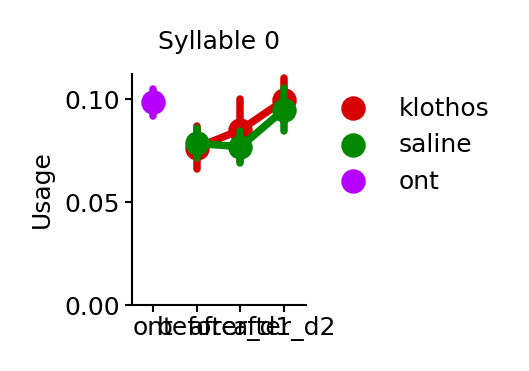

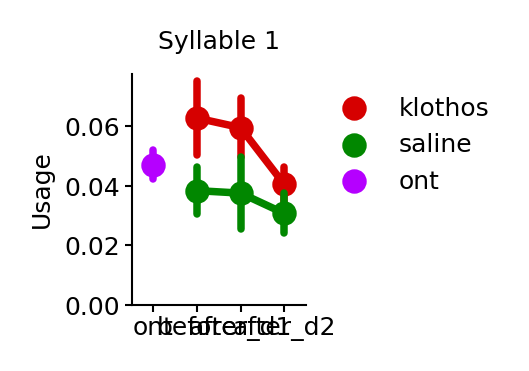

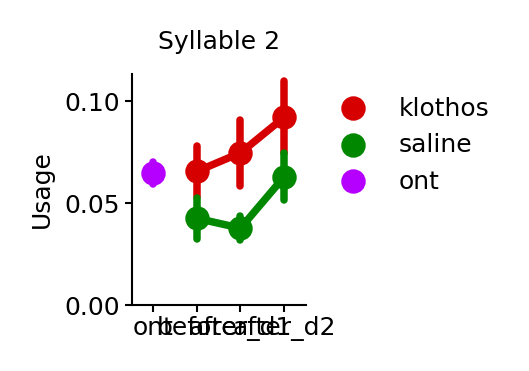

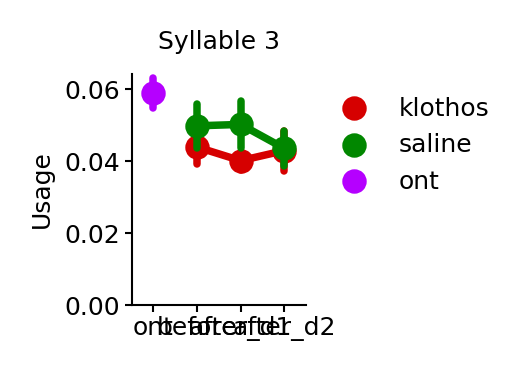

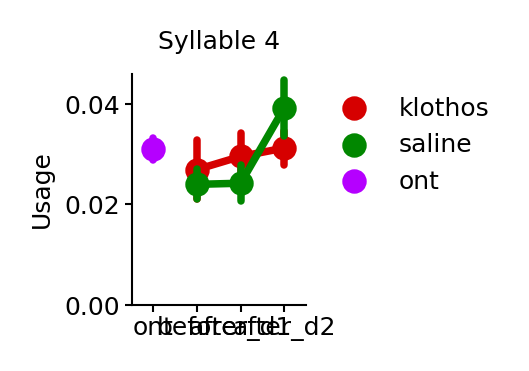

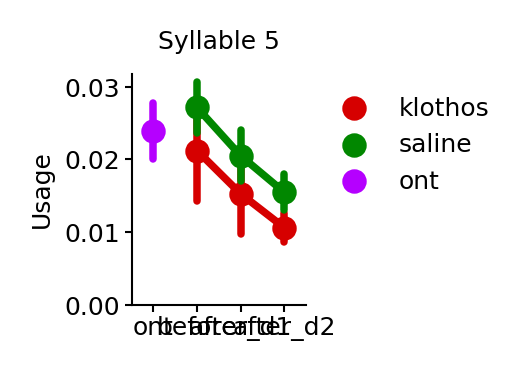

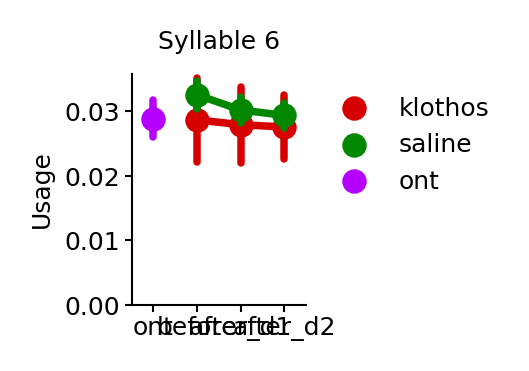

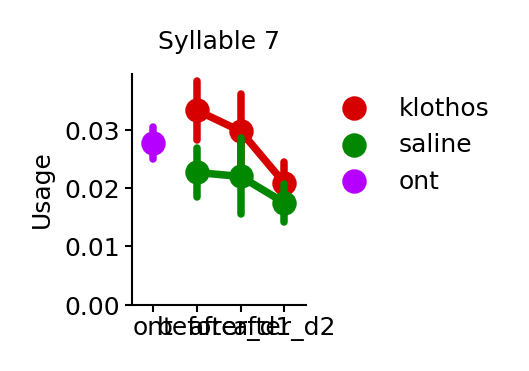

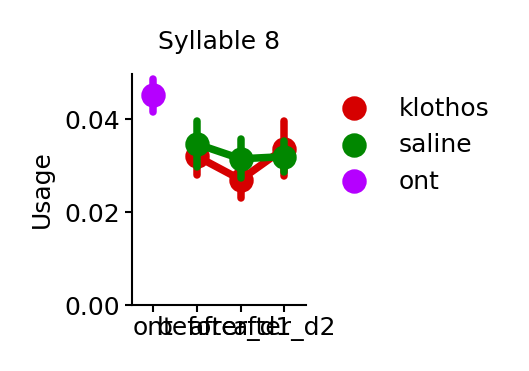

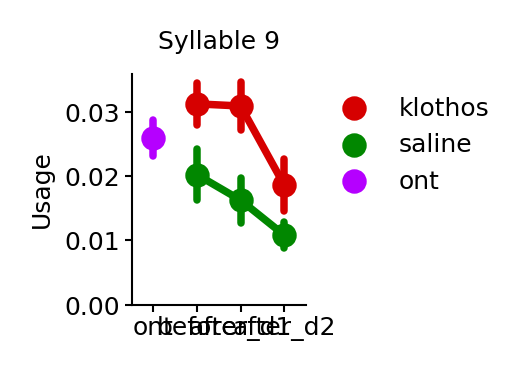

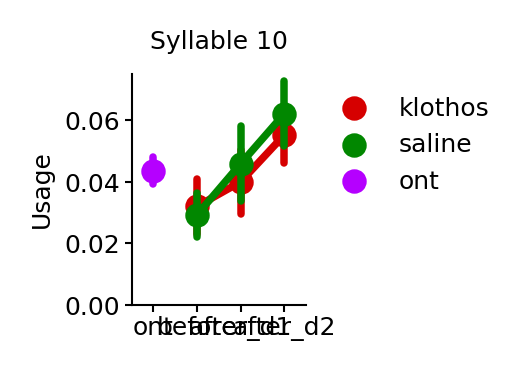

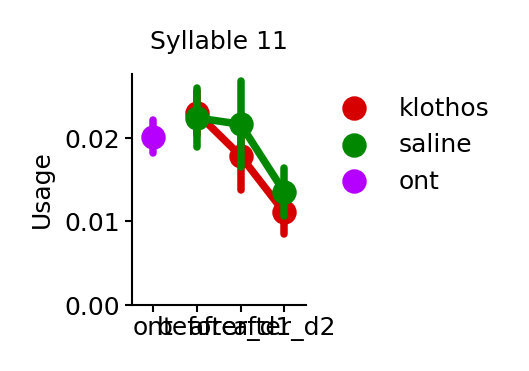

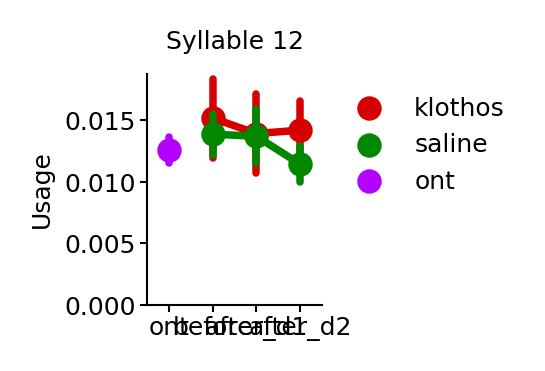

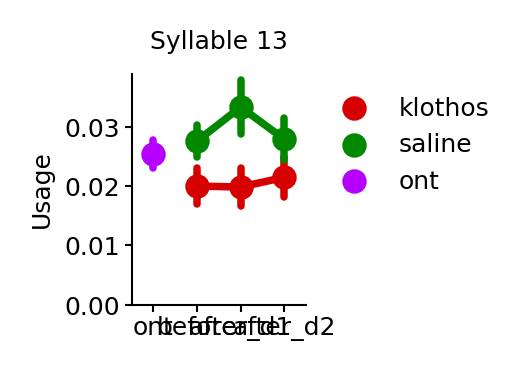

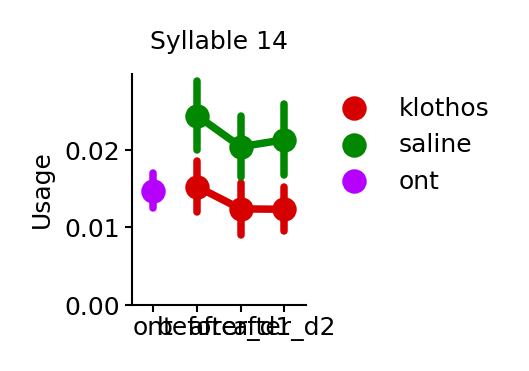

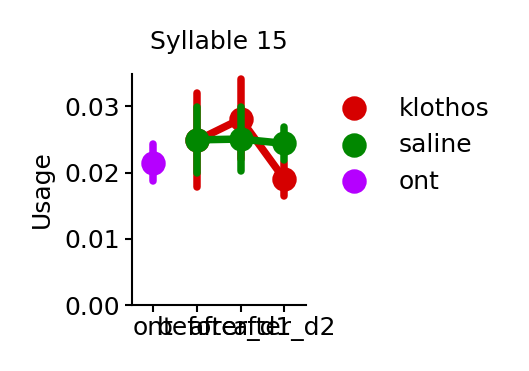

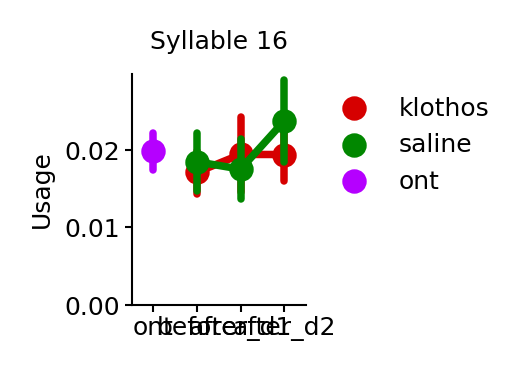

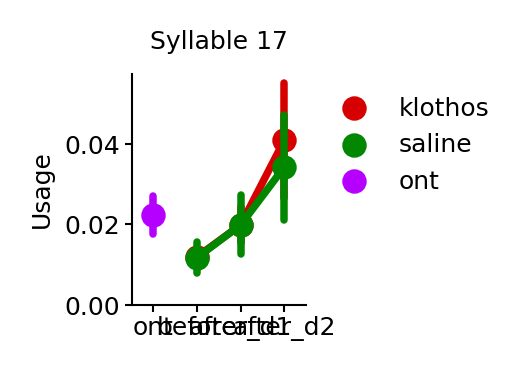

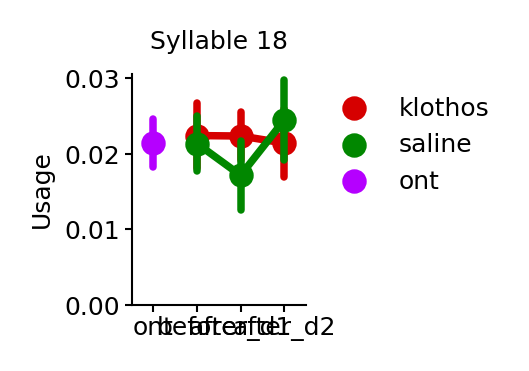

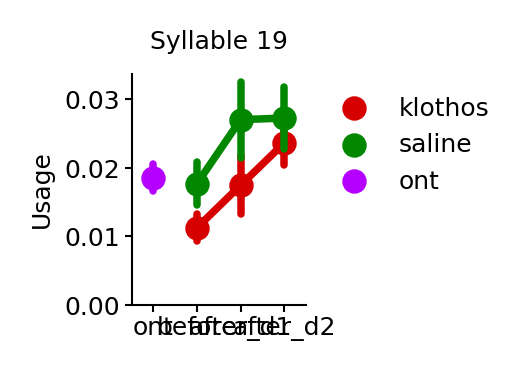

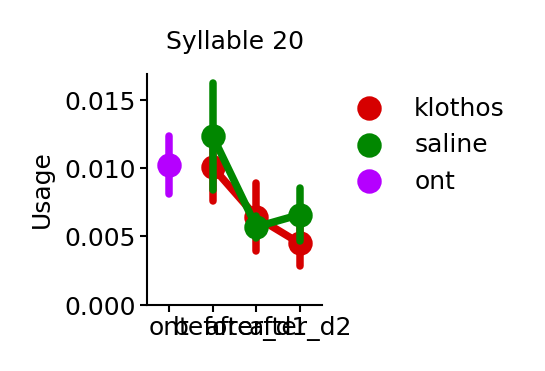

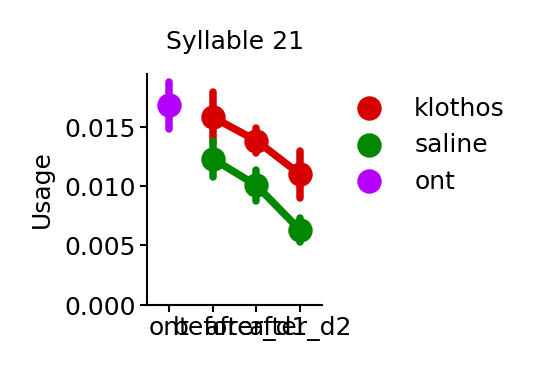

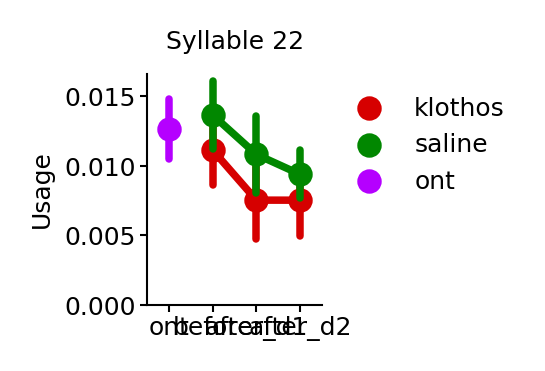

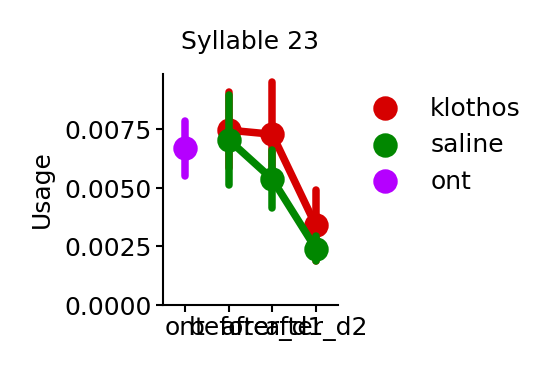

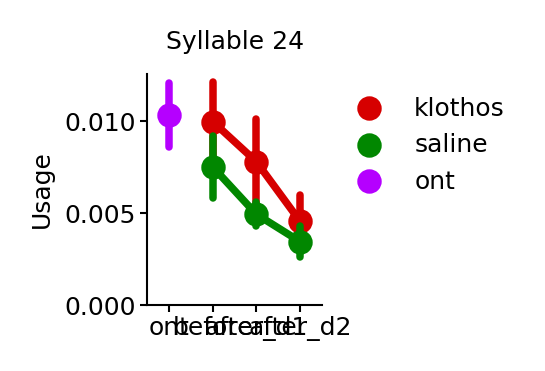

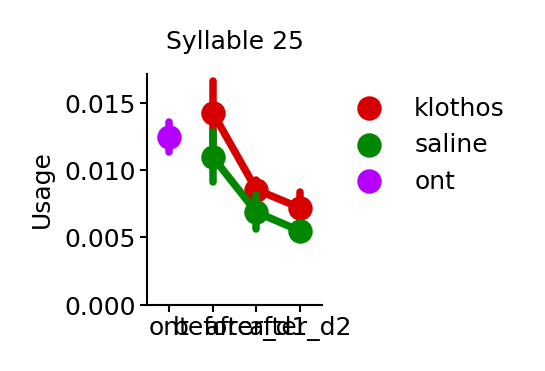

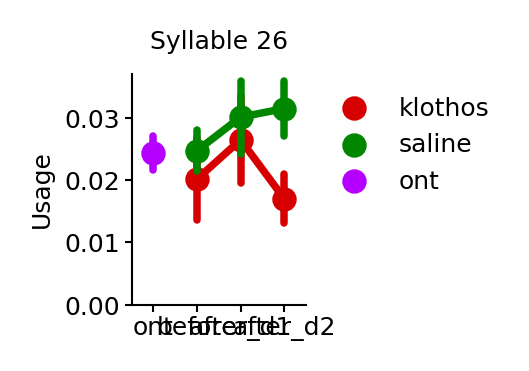

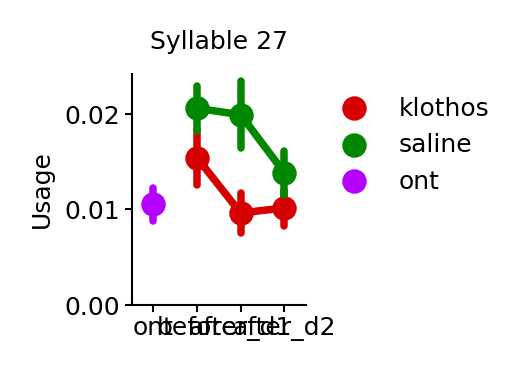

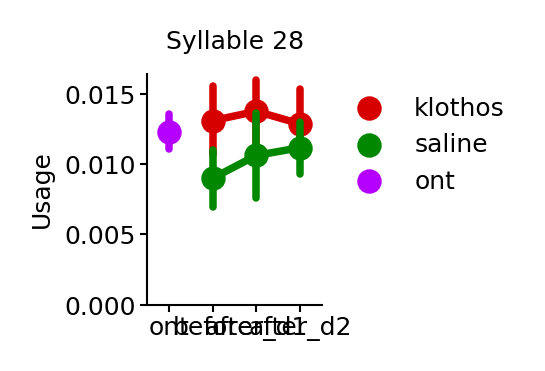

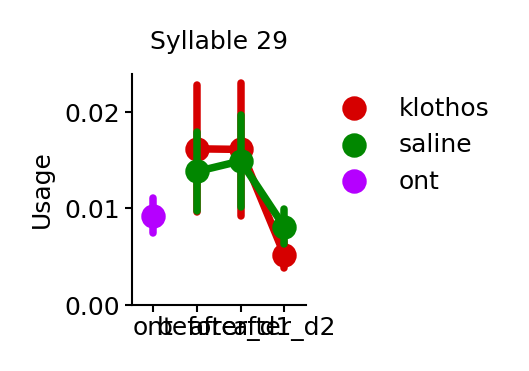

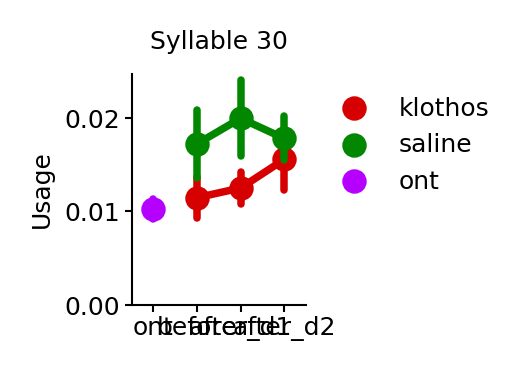

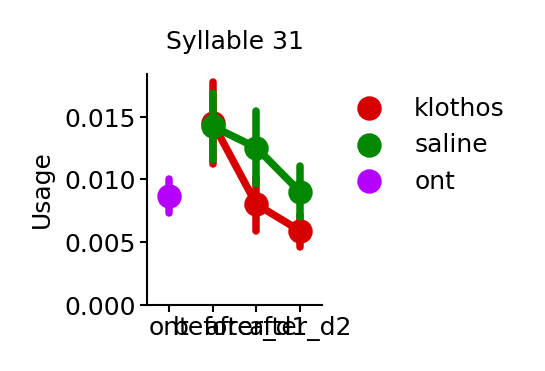

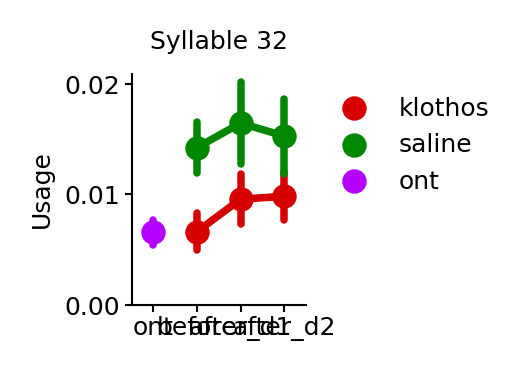

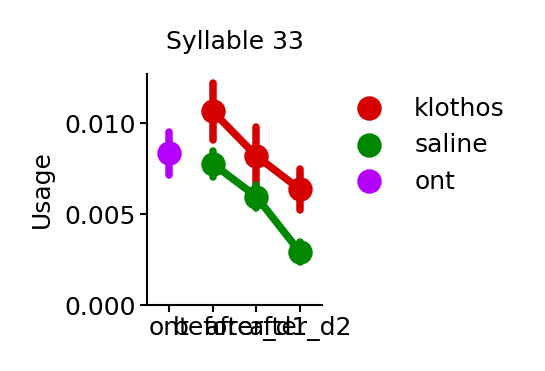

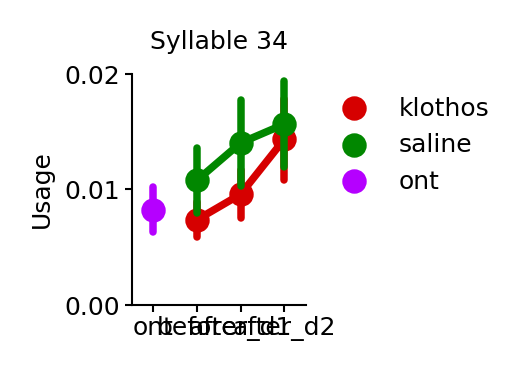

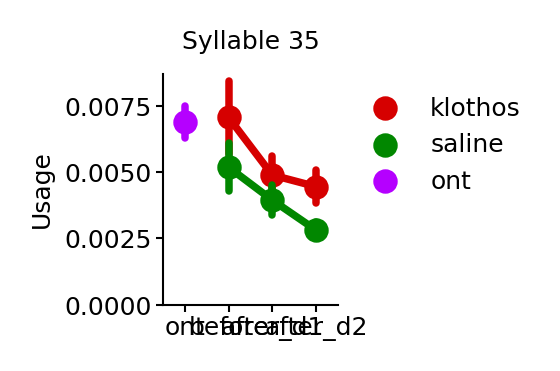

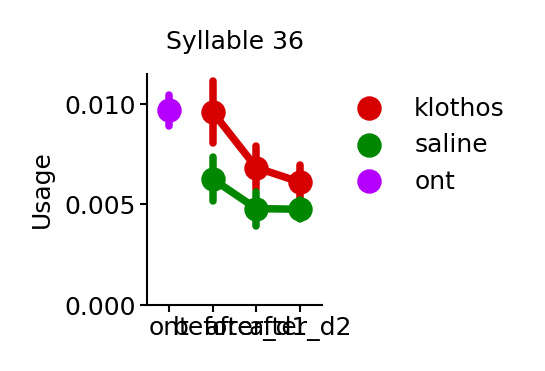

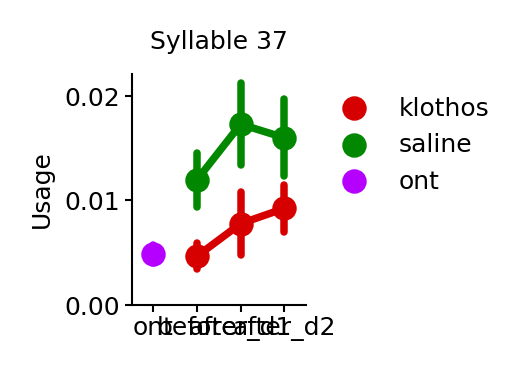

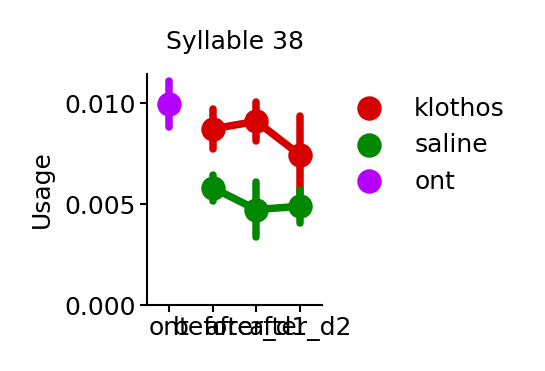

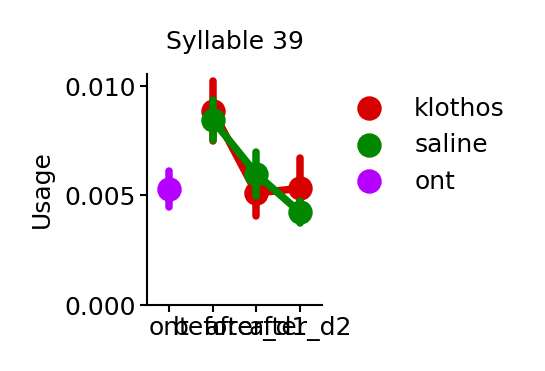

In [12]:
for syllable in range(40):
    fig = figure(0.75, 1)
    ax = sns.pointplot(
        data=combined.reset_index(),
        x="session_type",
        y=syllable,
        hue="exp_type",
        order=["ont","before", "after_d1",'after_d2'],
        palette=cc.glasbey_light[:3],
        #lw=1,
        #markersize=2.5, 
        errorbar='se',
    )
    ax.set(xlabel="", ylabel="Usage", title=f"Syllable {syllable}", ylim=(0, None))
    legend()
    sns.despine()

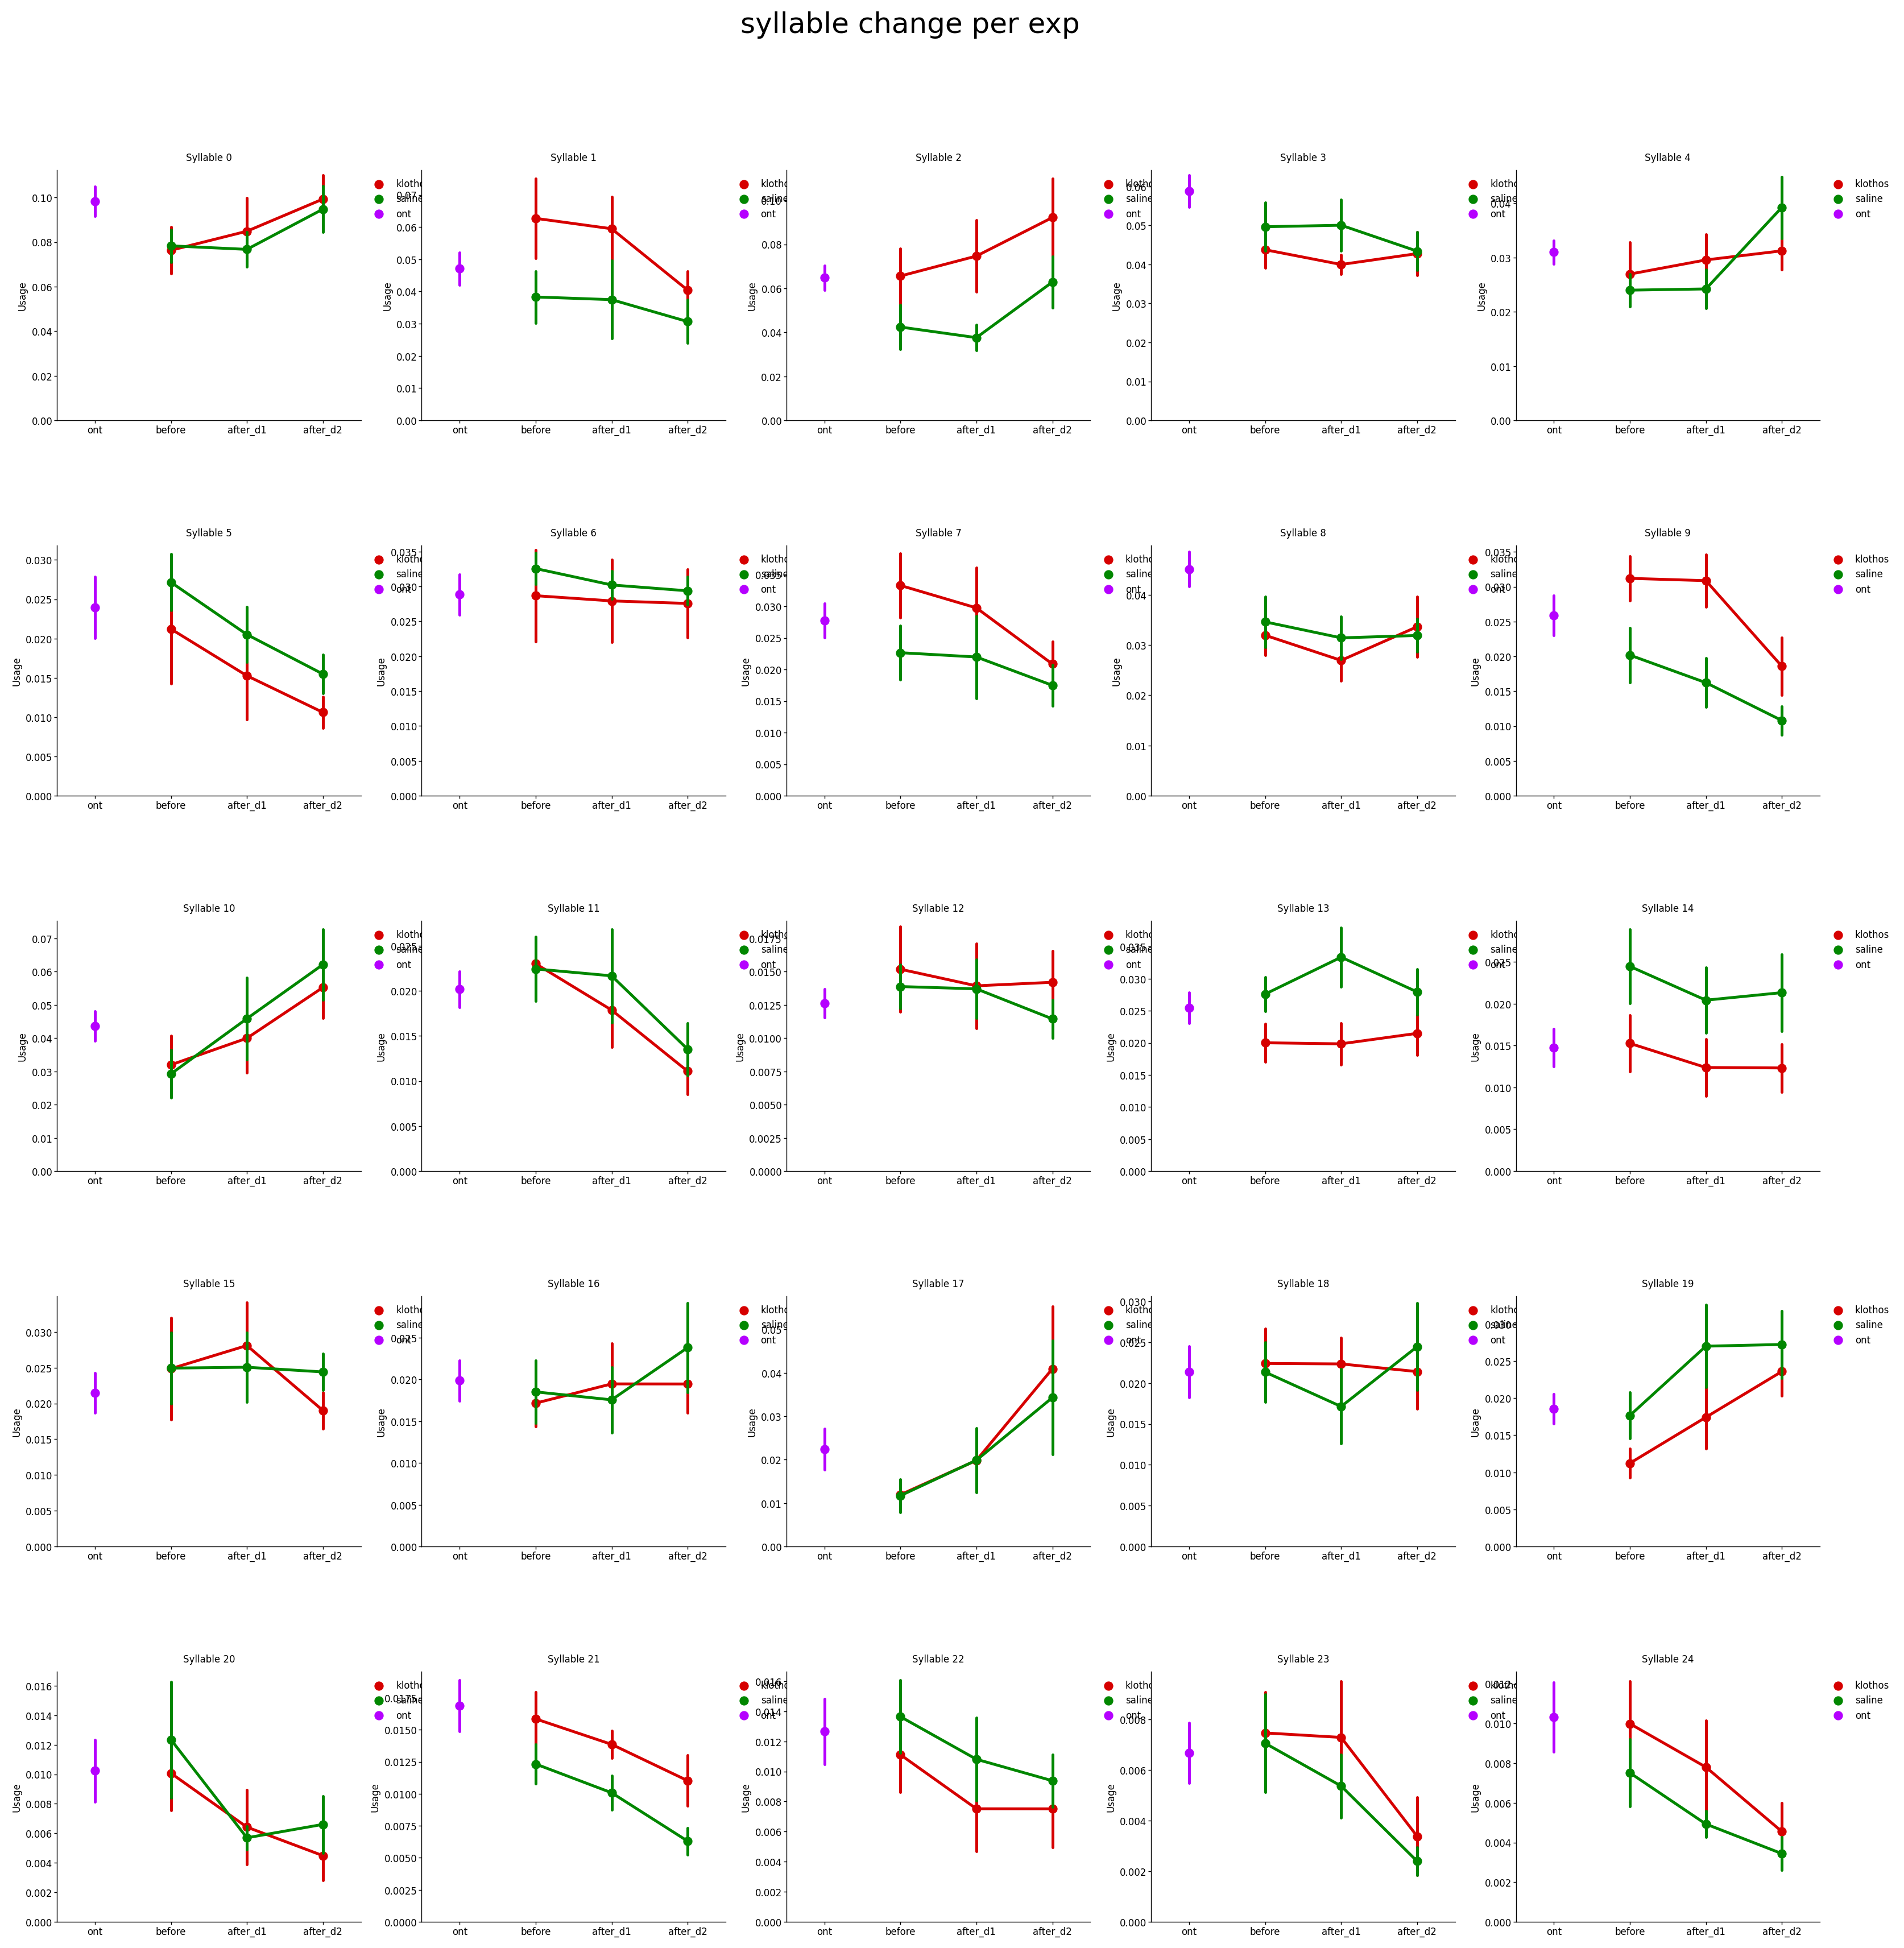

In [13]:
n=0
fig=plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("syllable change per exp", fontsize=18, y=0.95)
for syllable in range(25):
    ax = plt.subplot(5, 5, n + 1)
    sns.pointplot(
        data=combined.reset_index(),
        x="session_type",
        y=syllable,
        hue="exp_type",
        order=["ont","before", "after_d1",'after_d2'],
        palette=cc.glasbey_light[:3],
        #lw=1,
        #markersize=2.5, 
        errorbar='se',
    )
    ax.set(xlabel="", ylabel="Usage", title=f"Syllable {syllable}", ylim=(0, None))
    legend()
    sns.despine()
    n=n+1

In [14]:
## umap

In [24]:
#umap
import warnings

# Binning / smoothing
    
def firing_rates(
    spike_times, 
    spike_labels, 
    window_size=0.2, 
    window_step=0.02
):
    """Convert spike tikes to firing rates using a sliding window
    
    Parameters
    ----------
    spike_times : ndarray
        Spike times (in seconds) for all units. The source of each spike is
        input separately using ``spike_labels``
        
    spike_labels: ndarray
        The source/label for each spike in ``spike_times``. The maximum
        value of this array determines the number of rows in the heatmap.
    
    window_size: float, default=0.2
        Length (in seconds) of the sliding window used to calculate firing rates
        
    window_step: float, default=0.02
        Step-size (in seconds) between each window used to calculate firing rates
    Returns
    -------
    firing_rates: ndarray
        Array of firing rates, where rows units and columns are sliding 
        window locations. ``firing_rates`` has shape ``(N,M)`` where::
            N = max(spike_labels)+1
            M = (max(spike_times)-min(spike_times))/binsize
    start_time, float
        The time (in seconds) corresponding to the left-boundary
        of the first window in ``firing_rates``.
    """
    # round spikes to window_step and factor our start time
    spike_times = np.around(spike_times/window_step).astype(int)
    start_time = spike_times.min()
    spike_times = spike_times - start_time
    
    # create heatmap of spike counts for each window_step-sized bin
    spike_labels = spike_labels.astype(int)
    heatmap = np.zeros((spike_labels.max()+1, spike_times.max()+1))
    np.add.at(heatmap, (spike_labels, spike_times), 1/window_step)
    
    # use convolution to get sliding window counts
    kernel = np.ones(int(window_size//window_step))/(window_size//window_step)
    for i in range(heatmap.shape[0]): heatmap[i,:] = np.convolve(heatmap[i,:],kernel, mode='same')
    return heatmap, start_time-window_step/2


def bin_data(
    data, 
    binsize,
    axis=-1,
    return_intervals=False
):
    """Bin data using non-overlaping windows along `axis`
    Returns
    -------
    data_binned: ndarray
    bin_intervals: ndarray (returned if ``rerturn_intervals=True``)
        (N,2) array with the start and end index of each bin
    """
    data = np.moveaxis(data,axis,-1)
    pad_amount = (-data.shape[-1])%binsize
    num_bins = int((data.shape[-1]+pad_amount)/binsize)

    data_padded = np.pad(data,[(0,0)]*(len(data.shape)-1)+[(0,pad_amount)])
    data_binned = data_padded.reshape(*data.shape[:-1], num_bins, binsize).mean(-1)
    if pad_amount > 0: data_binned[...,-1] = data_binned[...,-1] * binsize/(binsize-pad_amount)
    data_binned = np.moveaxis(data_binned,-1,axis)

    if return_intervals:
        bin_starts = np.arange(0,num_bins)*binsize
        bin_ends = np.arange(1,num_bins+1)*binsize
        bin_ends[-1] = data.shape[-1]
        bin_intervals = np.vstack((bin_starts,bin_ends)).T
        return data_binned, bin_intervals
    else: return data_binned



# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std


# Dimensionality reduction

def sort(
    data, 
    method='rastermap', 
    options={}
):
    """Compute neuron ordering that groups neurons with similar activity
    Parameters
    ----------
    data: ndarray
        Data matrix where rows are neurons and columns are time points
    method: {'rastermap'}
        Method to use for sorting (currently only rastermap is implemented)
    options: dict, default={}
        Sorting method-specific options.
        'rastermap'
            ``options`` will be passed as keyword arguments when initializing
            `rastermap.mapping.Rastermap <https://github.com/MouseLand/rastermap/blob/40867ce9a8b2850d76483890740c0dc10d6cb413/rastermap/mapping.py#L531>`_
    Returns
    -------
    ordering: ndarray
        Ordering index that can be used for sorting (see `numpy.argsort`)
    """
    valid_sort_methods = ['rastermap']
    if not method in valid_sort_methods:
        raise AssertionError(method+' is not a valid sort method. Must be one of '+repr(valid_sort_methods))
    if method=='rastermap':
        print('Computing row order with rastermap')
        from rastermap import mapping
        model = mapping.Rastermap(n_components=1).fit(data)
        return np.argsort(model.embedding[:,0])


def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

In [38]:
data_umap = combined.groupby(['session_type','exp_type','age','uuid']).mean().copy()
exp = data_umap.index.get_level_values('session_type').unique().to_numpy()
data_umap_labels = data_umap.index.get_level_values('session_type').to_numpy()
# actual umap
coordinates = umap_embedding(data_umap.T, 
        standardize=False,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=10,
        random_state=42)

In [39]:
# transform exp type to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

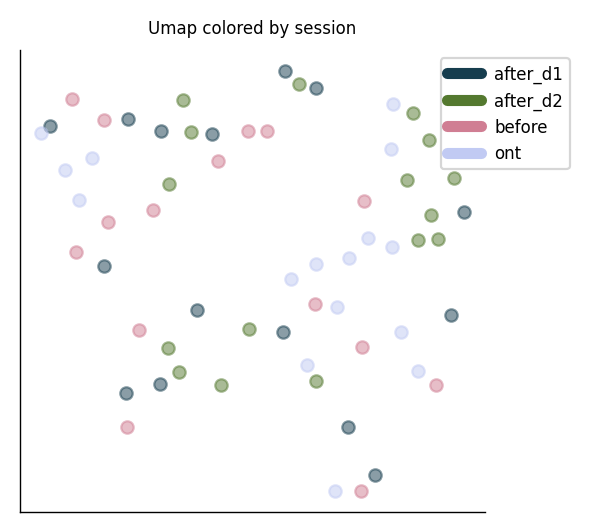

In [40]:
# plot
from matplotlib.lines import Line2D

# prepare colors for plot
phasec = sns.color_palette("cubehelix", 4)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by session',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

In [ ]:
## train age decoder and predict klotho age